# Natural Language Processing with Deep Learning (7 points)

Today we're gonna apply the newly learned DL tools for sequence processing to the task of predicting job salary.

Special thanks to [Oleg Vasilev](https://github.com/Omrigan/) for the assignment core (orignally written for theano/tensorflow).

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### About the challenge
For starters, let's download the data from __[here](https://yadi.sk/d/vVEOWPFY3NruT7)__.

You can also get it from the competition [page](https://www.kaggle.com/c/job-salary-prediction/data) (in that case, pick `Train_rev1.*`).


Our task is to predict one number, __SalaryNormalized__, in the sense of minimizing __Mean Absolute Error__.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3342/media/salary%20prediction%20engine%20v2.png" width=400px>

To do so, our model ca access a number of features:
* Free text: __`Title`__ and  __`FullDescription`__
* Categorical: __`Category`__, __`Company`__, __`LocationNormalized`__, __`ContractType`__, and __`ContractTime`__.


You can read more [in the official description](https://www.kaggle.com/c/job-salary-prediction#description).

In [2]:
#Data loader
'''Taken from discussion in DL chat'''
! pip3 install wldhx.yadisk-direct
! curl -L $(yadisk-direct https://disk.yandex.ru/d/vVEOWPFY3NruT7) -o Train_rev1.csv.zip
!unzip Train_rev1.csv.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  122M  100  122M    0     0  13.4M      0  0:00:09  0:00:09 --:--:-- 20.5M
Archive:  Train_rev1.csv.zip
  inflating: Train_rev1.csv          


In [3]:
data = pd.read_csv("./Train_rev1.csv", index_col=None)
data['Log1pSalary'] = np.log1p(data['SalaryNormalized']).astype('float32')

text_columns = ["Title", "FullDescription"]
categorical_columns = ["Category", "Company", "LocationNormalized", "ContractType", "ContractTime"]
target_column = "Log1pSalary"
data[categorical_columns] = data[categorical_columns].fillna('NaN') # cast nan to string

data.sample(3)['FullDescription']

23689     Previous cleaning experience an advantage but ...
150755    BID WRITER Construction experience of writing ...
110372    Technical Consultant An exciting opportunity a...
Name: FullDescription, dtype: object

In [4]:
data.sample(3)

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName,Log1pSalary
63160,68702931,Foster Carer Oxford,"Title: Foster Carer Location: Oxford, Oxfordsh...",Oxford Oxfordshire South East,Oxford,NaN,permanent,Simplified Recruitment,Healthcare & Nursing Jobs,"20,000 - 40,000 pa",30000,totaljobs.com,10.308986
244162,72694507,Embedded System Verification Engineer Embedded C,Embedded Systems Verification Engineer – Embed...,Bourne End Buckinghamshire England,Bourne End,NaN,NaN,Matchtech,Logistics & Warehouse Jobs,33000 -38000 per annum,35500,gojobsearch.co.uk,10.477316
34127,68204065,Digital Executives,Are you a creative Digital professional who ca...,Greater London,London,full_time,permanent,CANCER RESEARCH UK,Creative & Design Jobs,"Circa 23,750 - 28,750 p.a inclusive of locatio...",26250,jobs.guardian.co.uk,10.175459


### The NLP part

To even begin training our neural network, we're gonna need to preprocess the text features: tokenize it and build the token vocabularies.

Since it is not an NLP course, we're gonna use simple built-in NLTK tokenization.

In [5]:
print("Before")
print(data["Title"][::100000])

Before
0         Engineering Systems Analyst
100000                   HR Assistant
200000           Senior EC&I Engineer
Name: Title, dtype: object


In [0]:
import nltk
tokenizer = nltk.tokenize.WordPunctTokenizer()

for col in text_columns:
    data[col] = data[col].apply(lambda l: ' '.join(tokenizer.tokenize(str(l).lower())))

Now we can assume that our text is a space-separated list of tokens:

In [7]:
print("After")
print(data["Title"][::100000])

After
0         engineering systems analyst
100000                   hr assistant
200000         senior ec & i engineer
Name: Title, dtype: object


Not all words are equally useful. Some of them are typos or rare words that are only present a few times. 

Let's see how many times is each word present in the data so that we can build a "white list" of known words.

In [0]:
from collections import Counter
token_counts = Counter()

# Count how many times does each token occur in "Title" and "FullDescription"
tokens = []
for col in text_columns:
    for i in range(len(data[col])):
        tokens += data[col][i].split(' ')
token_counts = Counter(tokens)
tokens = []

In [9]:
print("Total unique tokens :", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

assert token_counts.most_common(1)[0][1] in  range(2600000, 2700000)
assert len(token_counts) in range(200000, 210000)
print('Correct!')

Total unique tokens : 202704
('and', 2657388)
('.', 2523216)
(',', 2318606)
('the', 2080994)
('to', 2019884)
...
('stephanietraveltraderecruitmnt', 1)
('ruabon', 1)
('lowehays', 1)
Correct!


Text(0.5, 0, 'Counts')

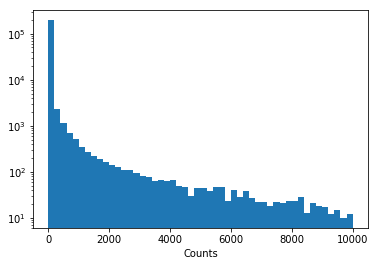

In [10]:
# Let's see how many words are there for each count

_ = plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Counts")

__Task 1.1__ Get a list of all tokens that occur at least 10 times.

In [0]:
min_count = 10

# tokens from token_counts keys that had at least min_count occurrences throughout the dataset
'''https://stackoverflow.com/questions/18807079/selecting-elements-of-a-python-dictionary-greater-than-a-certain-value'''
tokens = list(key for key, value in token_counts.items() if value >= min_count)

# Add a special tokens for unknown and empty words
UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

In [12]:
print("Tokens left:", len(tokens))
assert type(tokens)==list
assert len(tokens) in range(32000,35000)
assert 'me' in tokens
assert UNK in tokens
print("Correct!")

Tokens left: 34158
Correct!


__Task 1.2__ Build an inverse token index: a dictionary from token(string) to it's index in `tokens` (int)

In [0]:
token_to_id = dict((value,i) for i,value in enumerate(tokens))

In [14]:
assert isinstance(token_to_id, dict)
assert len(token_to_id) == len(tokens)
for tok in tokens:
    assert tokens[token_to_id[tok]] == tok

print("Correct!")

Correct!


And finally, let's use the vocabulary you've built to map text lines into torch-digestible matrices.

In [0]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):
    """ Convert a list of tokens into a matrix with padding """
    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix

In [16]:
print("Lines:")
print('\n'.join(data["Title"][::100000].values), end='\n\n')
print("Matrix:")
print(as_matrix(data["Title"][::100000]))

Lines:
engineering systems analyst
hr assistant
senior ec & i engineer

Matrix:
[[   2    3    4    1    1]
 [ 998  176    1    1    1]
 [  18 3472  242   59    6]]


Now let's  encode the categirical data we have.

As usual, we shall use one-hot encoding for simplicity. Kudos if you implement tf-idf, target averaging or pseudo-counter-based encoding.

In [17]:
from sklearn.feature_extraction import DictVectorizer

# we only consider top-1k most frequent companies to minimize memory usage
top_companies, top_counts = zip(*Counter(data['Company']).most_common(1000))
recognized_companies = set(top_companies)
data["Company"] = data["Company"].apply(lambda comp: comp if comp in recognized_companies else "Other")

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, separator='=', sort=True,
        sparse=False)

### The data science part

Once we've learned to tokenize the data, let's design a machine learning experiment.

As before, we won't focus too much on validation, opting for a simple train-test split.

__To be completely rigorous,__ we've comitted a small crime here: we used the whole data for tokenization and vocabulary building. A more strict way would be to do that part on training set only. You may want to do that and measure the magnitude of changes.

In [18]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data, test_size=0.1, random_state=42)

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  220291
Validation size =  24477


In [0]:
def generate_batch(data, batch_size=None, replace=True, max_len=None):
    """
    Creates a pytorch-friendly dict from the batch data.
    :returns: a dict with {'title' : int64[batch, title_max_len]
    """
    if batch_size is not None:
        data = data.sample(batch_size, replace=replace)
    
    batch = {}
    for col in text_columns:
        batch[col] = as_matrix(data[col].values, max_len)
    
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if target_column in data.columns:
        batch[target_column] = data[target_column].values
    
    return batch

In [20]:
generate_batch(data_train, 3, max_len=10)

{'Categorical': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 'FullDescription': array([[  360,  7460,    86, 12781,    86,   142,  2179,     9,   429,
          2256],
        [ 2497,   176,    88,   228,    18,   176,    88,  1464,   214,
            73],
        [ 2497,   296,  2358,   320,  2829,   558,  5782,    73,   561,
            27]], dtype=int32),
 'Log1pSalary': array([ 9.634104, 10.085851, 10.584082], dtype=float32),
 'Title': array([[ 2319,  6962,   380,    55,   579,     1,     1,     1,     1,
             1],
        [  176,    88,   561,   258,   259, 10878,  3014,    53,    74,
            82],
        [   27,    88,     1,     1,     1,     1,     1,     1,     1,
             1]], dtype=int32)}

### Finally, let's talk deep learning

Out model consists of three branches:
* Title encoder
* Description encoder
* Categorical features encoder

We will then feed all 3 branches into one common network that predicts salary.

![scheme](https://github.com/yandexdataschool/Practical_DL/raw/master/homework04/conv_salary_architecture.png)

By default, both text vectorizers shall use 1d convolutions, followed by global pooling over time.

In [0]:
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
    
class GlobalMaxPooling(nn.Module):
    def __init__(self, dim=-1):
        super(self.__class__, self).__init__()
        self.dim = dim
        
    def forward(self, x):
        return x.max(dim=self.dim)[0]

In [0]:
class TitleEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        """ 
        A simple sequential encoder for titles.
        x -> emb -> conv -> global_max -> relu -> dense
        """
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)

        
        
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        # added self.relu
        self.relu = nn.ReLU()
        
    def forward(self, text_ix):
        """
        :param text_ix: int64 Variable of shape [batch_size, max_len]
        :returns: float32 Variable of shape [batch_size, out_size]
        """
        h = self.emb(text_ix)

        # we transpose from [batch, time, units] to [batch, units, time] to fit Conv1d dim order
        h = torch.transpose(h, 1, 2)
        
        # Apply the layers as defined above. Add some ReLUs before dense.
        h1 = torch.cat([conv(h) for conv in [self.conv1, self.conv2, self.conv3]], dim = 2)
#         h1 = self.conv1(h)
        h2 = self.pool1(h1)
        h3 = self.relu(h2)
        h4 = self.dense(h3)
        return h4

In [23]:
title_encoder = TitleEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['Title']))
dummy_v = title_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)

del title_encoder
print("Seems fine")

Seems fine


__Task 2.1__ Create description encoder

In [0]:
# Define an encoder for job descriptions.
# Use any means you want so long as it's torch.nn.Module.
class DescriptionEncoder(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.conv1 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, out_size, kernel_size=3, padding=1)
        self.pool1 = GlobalMaxPooling()        
        self.dense = nn.Linear(out_size, out_size)
        # added self.relu
        self.relu = nn.ReLU()
        
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h = torch.transpose(h, 1, 2)
        h1 = torch.cat([conv(h) for conv in [self.conv1, self.conv2, self.conv3]], dim = 2)
#         h1 = self.conv1(h)
        h2 = self.pool1(h1)
        h3 = self.relu(h2)
        h4 = self.dense(h3)
        return h4

In [25]:
desc_encoder = DescriptionEncoder(out_size=64)

dummy_x = Variable(torch.LongTensor(generate_batch(data_train, 3)['FullDescription']))
dummy_v = desc_encoder(dummy_x)

assert isinstance(dummy_v, Variable)
assert tuple(dummy_v.shape) == (dummy_x.shape[0], 64)
del desc_encoder
print("Seems fine too")

Seems fine too


In [0]:
class DescriptionEncoderLSTM(nn.Module):
    def __init__(self, n_tokens=len(tokens), out_size=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(n_tokens, 64, padding_idx=PAD_IX)
        self.lstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)
        self.dense1 = nn.Sequential(nn.Linear(256, 128),
                                    nn.ReLU(),
                                    nn.BatchNorm1d(128))
        self.dense2 = nn.Linear(128, out_size)

                                   
    def forward(self, text_ix):
        h = self.emb(text_ix)
        h1 = self.lstm(h, (torch.randn(2, text_ix.size(0), 128).cuda(), torch.randn(2, text_ix.size(0), 128).cuda()))[0]
        h2 = self.dense1(h1[:,-1,:])
        h3 = self.dense2(h2)

        return h3

__Task 2.2__ Build one network ~~to rule them all~~

In [0]:
class FullNetwork(nn.Module):
    """
    This class does all the steps from (title, desc, categorical) features -> predicted target
    It unites title & desc encoders you defined above as long as some layers for head and categorical branch.
    """
    
    def __init__(self, n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_)):
        super(self.__class__, self).__init__()
        
        self.title_encoder = TitleEncoder(out_size=64)
        self.desc_encoder = DescriptionEncoderLSTM(out_size=64) #Change for DescriptionEncoder for Conv layers
        
        # define layers for categorical features. A few dense layers would do.
        self.categorical_encoder = nn.Sequential()
        self.categorical_encoder.add_module('dense1', nn.Linear(n_cat_features, 320))
        self.categorical_encoder.add_module('bn1', nn.BatchNorm1d(320))
        self.categorical_encoder.add_module('relu', nn.ReLU())
        self.categorical_encoder.add_module('dropout', nn.Dropout())
        self.categorical_encoder.add_module('dense2', nn.Linear(320, 64))
        

        
        # define "output" layers that process depend the three encoded vectors into answer
        self.output = nn.Sequential()
        self.output.add_module('dense1', nn.Linear(192, 320))
        self.output.add_module('relu', nn.ReLU())
        self.output.add_module('dense2', nn.Linear(320, 1))
        
        
        
    def forward(self, title_ix, desc_ix, cat_features):
        """
        :param title_ix: int32 Variable [batch, title_len], job titles encoded by as_matrix
        :param desc_ix:  int32 Variable [batch, desc_len] , job descriptions encoded by as_matrix
        :param cat_features: float32 Variable [batch, n_cat_features]
        :returns: float32 Variable 1d [batch], predicted log1p-salary
        """
        
        # process each data source with it's respective encoder
        title_h = self.title_encoder(title_ix)
        desc_h = self.desc_encoder(desc_ix)
        
        # apply categorical encoder
        cat_h = self.categorical_encoder(cat_features)
        
        # concatenate all vectors together...
        joint_h = torch.cat([title_h, desc_h, cat_h], dim=1)
        
        # ... and stack a few more layers at the top
        top = self.output(joint_h)[:,0]
        
        # Note 1: do not forget to select first columns, [:, 0], to get to 1d outputs
        # Note 2: please do not use output nonlinearities.
        
        return torch.log1p(top)

In [0]:
model = FullNetwork().cuda()
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

In [0]:
# test it on one batch

batch = generate_batch(data_train, 32)

title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

prediction = model(title_ix, desc_ix, cat_features)

assert len(prediction.shape) == 1 and prediction.shape[0] == title_ix.shape[0]

In [0]:
def compute_loss(reference, prediction):
    """
    Computes objective for minimization.
    By deafult we minimize MSE, but you are encouraged to try mix up MSE, MAE, huber loss, etc.
    """
    return torch.mean((prediction - reference) ** 2)

def compute_mae(reference, prediction):
    """ Compute MAE on actual salary, assuming your model outputs log1p(salary)"""
    return torch.abs(torch.exp(reference) - torch.exp(prediction)).mean()

In [0]:
loss = compute_loss(reference, prediction)
dummy_grads = torch.autograd.grad(loss, model.parameters(), retain_graph=True)
for grad in dummy_grads:
    assert grad is not None and not (grad == 0).all(), "Some model parameters received zero grads. " \
                                                       "Double-check that your model uses all it's layers."

### Let's train it!

In [0]:
from tqdm import tnrange
def iterate_minibatches(data, batch_size=32, max_len=None,
                        max_batches=None, shuffle=True, verbose=True):
    indices = np.arange(len(data))
    if shuffle:
        indices = np.random.permutation(indices)
    if max_batches is not None:
        indices = indices[: batch_size * max_batches]
        
    irange = tnrange if verbose else range
    
    for start in irange(0, len(indices), batch_size):
        yield generate_batch(data.iloc[indices[start : start + batch_size]], max_len=max_len)

In [0]:
num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 300

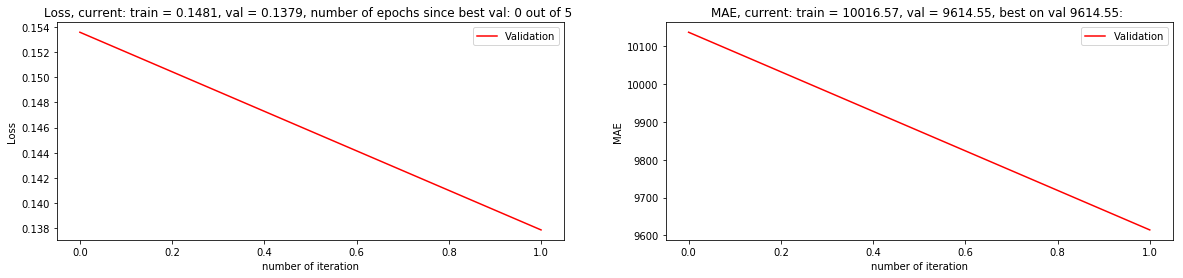

  2%|▏         | 2/100 [01:53<1:32:41, 56.75s/it]

KeyboardInterrupt: ignored

In [36]:
from IPython import display
from tqdm import trange

train_history_loss = []
train_history_mae = []
val_history_loss = []
val_history_mae = []
min_mae = np.inf

early_stop = 0
stop_criterion = 5

for epoch_i in trange(num_epochs):
    
#     print("Training:")
    train_loss = train_mae = train_batches = 0 
    model.train(True)
    
    for batch in iterate_minibatches(data_train, max_batches=batches_per_epoch):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

        prediction = model(title_ix, desc_ix, cat_features)

        loss = compute_loss(reference, prediction)
        loss.backward()
        opt.step()
        opt.zero_grad()

        train_loss += loss.cpu().data.numpy()
        train_mae += compute_mae(reference, prediction).cpu().data.numpy()
        train_batches += 1
    
    train_history_loss.append(train_loss / train_batches)
    train_history_mae.append(train_mae / train_batches)
#     print("\tLoss:\t%.5f" % (train_loss / train_batches))
#     print("\tMAE:\t%.5f" % (train_mae / train_batches))
#     print('\n\n')
    
#     print("Validation:")
    val_loss = val_mae = val_batches = 0
    model.train(False)
    
    for batch in iterate_minibatches(data_val, shuffle=False):
        title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
        desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
        cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
        reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()
        prediction = model(title_ix, desc_ix, cat_features)
        loss = compute_loss(reference, prediction)

        val_loss += loss.cpu().data.numpy()
        val_mae += compute_mae(reference, prediction).cpu().data.numpy()
        val_batches += 1
        
    val_history_loss.append(val_loss / val_batches)  
    val_history_mae.append(val_mae / val_batches)
#     print("\tLoss:\t%.5f" % (val_loss / val_batches))
#     print("\tMAE:\t%.5f" % (val_mae / val_batches))
#     print('\n\n')
    
    if val_history_mae[-1] < min_mae:
            min_mae = val_history_mae[-1]
            best_model = torch.save(model.state_dict(), './best_NN_params.pt')
            early_stop = 0
    else:
        early_stop += 1
        if early_stop == stop_criterion:
            break
            
    display.clear_output(wait=True)
    
    plt.figure(figsize = (20,4))
    plt.subplot(1,2,1)
    plt.title('Loss, current: train = {}, val = {}, number of epochs since best val: {} out of {} '.format(round(train_history_loss[-1],4), round(val_history_loss[-1],4), early_stop, stop_criterion))
    plt.xlabel('number of iteration')
    plt.ylabel('Loss')
    plt.plot(val_history_loss, color = 'red', lw = 1.5, label = 'Validation')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(val_history_mae, color = 'red', lw = 1.5, label = 'Validation')
    plt.title('MAE, current: train = {}, val = {}, best on val {}: '.format(round(train_history_mae[-1],2), round(val_history_mae[-1],2), round(min_mae,2)))
    plt.xlabel('number of iteration')
    plt.ylabel('MAE')
    plt.legend()
    plt.show()

In [0]:
print("Final eval:")
val_loss = val_mae = val_batches = 0
net = FullNetwork().cuda()
net.load_state_dict(torch.load('best_NN_params.pt'))
net.eval()
for batch in iterate_minibatches(data_val, shuffle=False):
    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    reference = torch.tensor(batch[target_column], dtype=torch.float32).cuda()

    prediction = net(title_ix, desc_ix, cat_features)
    loss = compute_loss(reference, prediction)

    val_loss += loss.cpu().data.numpy()
    val_mae += compute_mae(reference, prediction).cpu().data.numpy()
    val_batches += 1

print("\tLoss:\t%.5f" % (val_loss / val_batches))
print("\tMAE:\t%.5f" % (val_mae / val_batches))
print('\n\n')

### Task 3: explaining network predictions

It's usually a good idea to understand what your model does before you let it make actual decisions. It's simple for linear models: just see which words learned positive or negative weights. However, its much harder for neural networks that learn complex nonlinear dependencies.

There are, however, some ways to look inside the black box:
* Seeing how model responds to input perturbations
* Finding inputs that maximize/minimize activation of some chosen neurons (_read more [on distill.pub](https://distill.pub/2018/building-blocks/)_)
* Building local linear approximations to your neural network: [article](https://arxiv.org/abs/1602.04938), [eli5 library](https://github.com/TeamHG-Memex/eli5/tree/master/eli5/formatters)

Today we gonna try the first method just because it's the simplest one.

__Your task__ is to measure how does model prediction change if you replace certain tokens with UNKs. The core idea is that if dropping a word from text causes model to predict lower log-salary, than this word probably has positive contribution to salary (and vice versa).

In [0]:
def explain(model, sample, col_name='Title'):
    """ Computes the effect each word had on model predictions """
    
    # compute model prediction on sample (scalar float log-salary)
    
    model.train(False)
    batch = generate_batch(sample.to_frame().T)

    title_ix = torch.tensor(batch["Title"], dtype=torch.int64).cuda()
    desc_ix = torch.tensor(batch["FullDescription"], dtype=torch.int64).cuda()
    cat_features = torch.tensor(batch["Categorical"], dtype=torch.float32).cuda()
    
    baseline_pred = model(title_ix, desc_ix, cat_features).cpu().data.item()
    
    # for each i-th token in :col_name:, compute predictions on a copy of data
    # where i-th token is dropped (UNK)
    
    predictions_without_word = []
    for i in range(len(sample[col_name].split(' '))):
        tokens = sample[col_name].split(' ')
        tokens[i] = 'UNK'
        sample_copy = sample.copy()
        sample_copy[col_name] = tokens
        batch_copy = generate_batch(sample_copy.to_frame().transpose())
        title_ix_copy = torch.tensor(batch_copy["Title"], dtype=torch.int64).cuda()
        desc_ix_copy = torch.tensor(batch_copy["FullDescription"], dtype=torch.int64).cuda()
        cat_features_copy = torch.tensor(batch_copy["Categorical"], dtype=torch.float32).cuda()
    
        predictions_without_word.append(model(title_ix_copy, desc_ix_copy, cat_features_copy).cpu().data.item())
    score_differences = [prediction - baseline_pred for prediction in predictions_without_word]
    
    # return a list of pairs: [(token, score_difference)]
    return list(zip(sample[col_name].split(' '), score_differences))

In [0]:
# debugging area
sample = data.loc[np.random.randint(len(data))]
print("Input:", sample)

tokens_and_weights = explain(model, sample, "Title")
print(tokens_and_weights)

In [0]:
from IPython.display import HTML, display_html

def draw_html(tokens_and_weights, cmap=plt.get_cmap("bwr"), display=True,
              token_template="""<span style="background-color: {color_hex}">{token}</span>""",
              font_style="font-size:14px;"
             ):
    
    def get_color_hex(weight):
        rgba = cmap(1. / (1 + np.exp(weight)), bytes=True)
        return '#%02X%02X%02X' % rgba[:3]
    
    tokens_html = [
        token_template.format(token=token, color_hex=get_color_hex(weight))
        for token, weight in tokens_and_weights
    ]
    
    
    raw_html = """<p style="{}">{}</p>""".format(font_style, ' '.join(tokens_html))
    if display:
        display_html(HTML(raw_html))
        
    return raw_html
    

In [0]:
i = np.random.randint(len(data))
sample = data.loc[i]
print("Index:", i)

# predict salary on sample
batch_sample = generate_batch(sample.to_frame().T)
title_ix_sample = torch.tensor(batch_sample["Title"], dtype=torch.int64).cuda()
desc_ix_sample = torch.tensor(batch_sample["FullDescription"], dtype=torch.int64).cuda()
cat_features_sample = torch.tensor(batch_sample["Categorical"], dtype=torch.float32).cuda()

print("Salary (gbp):", model(title_ix_sample, desc_ix_sample, cat_features_sample).cpu().data.item())

tokens_and_weights = explain(model, sample, "Title")
draw_html([(tok, weight * 10) for tok, weight in tokens_and_weights], font_style='font-size:20px;');

tokens_and_weights = explain(model, sample, "FullDescription")
draw_html([(tok, weight * 1000) for tok, weight in tokens_and_weights]);

### Task 4: Actually make it work

Your main task is to use some of the tricks you've learned on the network and analyze if you can improve __validation MAE__.

Try __at least 3 options__ from the list below for a passing grade. If you're into 

#### A) CNN architecture

All the tricks you know about dense and convolutional neural networks apply here as well.
* Dropout. Nuff said.
* Batch Norm. This time it's `nn.BatchNorm1d`
* Parallel convolution layers. The idea is that you apply several nn.Conv1d to the same embeddings and concatenate output channels.
* More layers, more neurons, ya know...


#### B) Play with pooling

There's more than one way to do max pooling:
* Max over time - our `GlobalMaxPooling`
* Average over time (excluding PAD)
* Softmax-pooling:
$$ out_{i, t} = \sum_t {h_{i,t} \cdot {{e ^ {h_{i, t}}} \over \sum_\tau e ^ {h_{j, \tau}} } }$$

* Attentive pooling
$$ out_{i, t} = \sum_t {h_{i,t} \cdot Attn(h_t)}$$

, where $$ Attn(h_t) = {{e ^ {NN_{attn}(h_t)}} \over \sum_\tau e ^ {NN_{attn}(h_\tau)}}  $$
and $NN_{attn}$ is a small neural network


The optimal score is usually achieved by concatenating several different poolings, including several attentive pooling with different $NN_{attn}$

#### C) Fun with embeddings

It's not always a good idea to train embeddings from scratch. Here's a few tricks:

* Use a pre-trained word2vec from [here](http://ahogrammer.com/2017/01/20/the-list-of-pretrained-word-embeddings/) or [here](http://mccormickml.com/2016/04/12/googles-pretrained-word2vec-model-in-python/).
* Start with pre-trained embeddings, then fine-tune them with gradient descent
* Use the same embedding matrix in title and desc vectorizer

#### D) Going recurrent

We've already learned that recurrent networks can do cool stuff in sequence modelling. Turns out, they're not useless for classification as well. With some tricks of course..

* Like convolutional layers, LSTM should be pooled into a fixed-size vector with some of the poolings.
  * Please bear in mind that while convolution uses [batch, units, time] dim order, 
    recurrent units are built for [batch, time, unit]. You may need to `torch.transpose`.

* Since you know all the text in advance, use bidirectional RNN
  * Run one LSTM from left to right
  * Run another in parallel from right to left 
  * Concatenate their output sequences along unit axis (dim=-1)

* It might be good idea to mix convolutions and recurrent layers differently for title and description


#### E) Optimizing seriously

* You don't necessarily need 100 epochs. Use early stopping. If you've never done this before, take a look at [keras](https://github.com/keras-team/keras/blob/master/keras/callbacks.py#L461) for inspiration.
  * In short, train until you notice that validation
  * Maintain the best-on-validation snapshot via `model.state_dict`
  * Plotting learning curves is usually a good idea

### A short report

Please tell us what you did and how did it work.



## A Short report
* First of all, according to DL chat, I fixed MAE metrics, because I similar kaggle competition the winning solution receives about 3500 MAE, but I early implementation the starting MAE was lower, that 3000.

* Secondly, I have adjusted codeflow for GPU (by moving tensors to CUDA) to Improve performance of computation. 

* After that I have implemented baseline and implemented statement **E)**, where the goal was to visualize validation loss and MAE curves, implemented  best-on-validation snapshot, which is saved with **best_NN_params.pt** file.  What is more, main information is printed on graphs titles (metrics, loss values, `stop_criterion` and early stop counter)

* What is more, early stop was implemented in such way: if the validation MAE comes to local minimum, we save this value and of the next epochs we compare this best value with the current one. If we have the lower current value, that the best we rewrite the local minimum value, otherwise we start the counter of waiting epochs. If this counter reaches ``stop_criterion``, we stop training. 

* After that, I started training on baseline, to understand the MAE value, which I will optimize during the next steps. The parameters for training will be similar for all implementations: 
`num_epochs = 100
max_len = 100
batch_size = 32
batches_per_epoch = 300`

* **So on validation on baseline MAE with segment E) was 8236, loss was 0.10752.**

* After that I've implemented statement **A)**, added ```Conv1d``` concatenation (3 parallel convolutional layers) and Batch Normalization `BatchNorm1d, DropOut`.  Also added amount of neurons in each layer.  
*  **So on validation after implementation of A) segment MAE was 7208, loss was 0.07926**
* After that, I managed to implement LSTM description decoder, based on one (without concatenation  with the reverse one) biLSTM, the given result was better, than the baseline, but it's worse, that the previous one. But as far as I discovered it tend to better performance in less epochs in comparison with A) segment. 
* **So on validation after implementation of C) segment MAE was 7208, loss was 0.07926**